In [1]:
import numpy as np
from numba import cuda
import math
import scipy.signal as scs
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pickle

### load data

In [2]:
# Data were acquired using ur4R_lite system.
# Plane Wave Imaging (PWI) sequence was used in measurement.

# Load data from a file.
filename = 'pwi_wire_angles-10_0_10_50V_context.pkl'
file = open(filename,'rb')
datadict = pickle.load(file)

# metadata, from the parameters will be taken
metadata = datadict['metadata']


# radio-frequency data
rf = datadict['data']

# sampling frequency
dwnsmp = metadata['sequence']['downsampling_factor']
fs = metadata['device']['sampling_frequency']/dwnsmp

# pitch
pitch = metadata['device']['probe']['model']['pitch']

# transmission angles
tx_angle = metadata['sequence']['angles']

# speed of sound
c = metadata['sequence']['speed_of_sound']

# carrier frequency
fc = metadata['sequence']['pulse']['center_frequency']

# 
n_periods = metadata['sequence']['pulse']['n_periods']


if 'tx_focus' in metadata['sequence']:
    tx_focus = metadata['sequence']['tx_focus']

else:
    tx_focus = 0
    print('pwi sequence: tx_focus = 0')
    

print('Data loaded.')


pwi sequence: tx_focus = 0
Data loaded.


In [3]:
# device function   
@cuda.jit(device=True)
def pixel(px, pz, angle, elx, c, fs, rf):
    """
    Device function. 
    Returns the value in single pixel of the reconstructed image 
    for Plane Wave Imaging scheme with tx angle = 0 degree.
    
    px: x coordinate of the image pixel,
    pz: z coordinate of the image pixel,
    angle: wave angle of incidence,
    elx: vector of x coordinates of the transducer elements,
    c: speed of sound in the medium,
    fs: sampling frequency,
    rf: 2D array of ultrasound signals acquired by the transducer. 
        rf.shape = (number_of_elements, number_of_samples)
    """
    
    if angle >= 0:
        pw = elx[0]
    else:
        pw = elx[-1]

    # sum suitable samples from signals acquired by each transducer element
    pixval = 0
    for ielement in range(elx.shape[0]):
        sample_number = round((pz*math.cos(angle) - pw*math.sin(angle) + px*math.sin(angle) + 
                               math.sqrt(pz**2 + (px-elx[ielement])**2)
                              )/c*fs)
        
#         sample_number = round((pz*math.cos(angle/2) + 0.5*px*math.sin(angle) + 
#                        math.sqrt(pz**2 + (px-elx[ielement])**2)
#                       )/c*fs);
        pixval += rf[ielement,sample_number]

    return pixval    
    
    
# kernel    
@cuda.jit
def allpixels(xgrid, zgrid, angle, elx,c,fs,rf,image):
    """
    Kernel function.
    Enumerates values in all pixels of the reconstructed image
    for Plane Wave Imaging scheme with tx angle = 0 degree.
    
    xgrid: 2D array of image pixels x coordinates,
    zgrid: 2D array of image pixels z coordinates,
    elx: vector of x coordinates of the transducer elements,
    c: speed of sound in the medium,
    fs: sampling frequency,
    rf: ultrasound signals acquired by the transducer,
    image: pre-allocated device ndarray for image data
    """

    i, j, k = cuda.grid(3)
    if i > image.shape[0] or j > image.shape[1] or k > image.shape[2]:
        return
    
    # kernel does not return a value - it modifies one of arguments into result
    image[i,j,k] = pixel(xgrid[i,j],zgrid[i,j],angle[k],elx,c,fs,rf[k,:,:])
    
    

def beamforming(xgrid, zgrid, angle, elx,c,fs,rf):
    """
    Function beamforming ultrasound data into image using GPU kernel.
    Returns beamformed image (ndarray).

    xgrid: 2D array of image pixels x coordinates,
    zgrid: 2D array of image pixels z coordinates,
    elx: vector of x coordinates of the transducer elements,
    c: speed of sound in the medium,
    fs: sampling frequency,
    rf: ultrasound signals acquired by the transducer,
    """
    # images array dimensions
    nx = xgrid.shape[1]
    nz = zgrid.shape[0]
    ny = angle.shape[0]
    
    # allocate output array on the device
    img = cuda.device_array((nz,nx,ny))
    
    # put data and grid arrays to the device
    xgrid = cuda.to_device(xgrid)
    zgrid = cuda.to_device(zgrid)
    angle = cuda.to_device(angle)
    elx = cuda.to_device(elx)
    rf = cuda.to_device(rf)

    
    
    # define thread per block and blocks per grid size
    blockshape = (16,16,3)
    gridshape_z = (nz + blockshape[0] - 1) // blockshape[0]
    gridshape_x = (nx + blockshape[1] - 1) // blockshape[1]
    gridshape_y = (ny + blockshape[2] - 1) // blockshape[2]
    gridshape = (gridshape_z, gridshape_x, gridshape_y)
    
    # run kernel
    allpixels[gridshape,blockshape](xgrid, zgrid, angle, elx, c, fs,rf,img)
    
    # transfer data from device to host
    img = img.copy_to_host()
    return img

def envdb(img):
    """
    Auxiliary function for image envelope detection and log-compression.
    """
    
    env = np.abs(scs.hilbert(img,axis=0))
    mx = np.max(env)
    env = env/mx
    env = 20*np.log10(env)
    return env

def showresult(xgrid,zgrid,rf_image,dynamic=[-30,0]):
    
    # calculate data aspect for proper image proportions
    dx = xgrid[0][1]-xgrid[0][0]
    dz = zgrid[1][0]-zgrid[0][0]
    data_aspect = dz/dx


    fig, axes = plt.subplots()
    axes.imshow(envdb(np.sum(rf_image,axis=2)),
                interpolation='bicubic',
                aspect=data_aspect,
                cmap='gray',
                vmin=dynamic[0], vmax=dynamic[1]
                  )

#     fig.tight_layout()    
    

## Use of defined functions on loaded data

CPU times: user 21.8 ms, sys: 5.06 ms, total: 26.9 ms
Wall time: 25.4 ms
(3,)


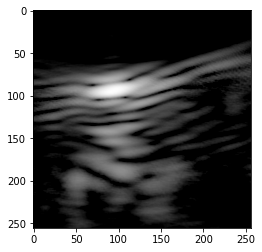

In [7]:
    
n_transmissions,n_channels,n_samples  = rf.shape    
probe_width = (n_channels-1)*pitch
elx = np.linspace(-probe_width/2, probe_width/2, n_channels)

x_mm = [-1,1]
z_mm = [24,26]
nx = 256
nz = 256

# create image grids
xgrid = np.linspace(x_mm[0]*1e-3,x_mm[1]*1e-3,nx)
xgrid = np.expand_dims(xgrid,axis=0)
xgrid = np.tile(xgrid,(nz,1))

zgrid = np.linspace(z_mm[0]*1e-3,z_mm[1]*1e-3,nz)
zgrid = np.expand_dims(zgrid,axis=1)
zgrid = np.tile(zgrid,(1,nx))


# do beafmorming
%time rf_image = beamforming(xgrid,zgrid,tx_angle,elx,c, fs,rf)

# present results
showresult(xgrid,zgrid,rf_image)